# **Import Library**

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile, os
import shutil 
import glob

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.utils import np_utils

In [2]:
# input kaggle credentials
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"stanjk","key":"3f98d6c4e969d21915bc2a4c70ae9b70"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


datasetnya mau pakai yang mana?
1. https://www.kaggle.com/lavaman151/plantifydr-dataset
2. https://www.kaggle.com/vipoooool/new-plant-diseases-dataset
3. https://data.mendeley.com/datasets/tywbtsjrjv/1

In [4]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.70G/2.70G [00:41<00:00, 38.0MB/s]
100% 2.70G/2.70G [00:41<00:00, 70.5MB/s]


# **Rename and Move Dataset Folder**

In [5]:
# run once
local_zip = 'new-plant-diseases-dataset.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/')

In [6]:
os.rename('/New Plant Diseases Dataset(Augmented)', '/plant')
os.rename('/plant/New Plant Diseases Dataset(Augmented)', '/plant/plant')

In [7]:
file = os.listdir('/plant/plant')
for fn in file:
  original = r'/plant/plant/{}'.format(fn)
  target = r'/plant/{}'.format(fn)
  shutil.move(original,target)

# **[Corn]**

## **Only take corn**

In [8]:
plant_use = ['Corn']

for plant in plant_use:
  print(len(glob.glob("/plant/train/{}*".format(plant))))

4


In [9]:
base_dir = '/plant'
corn_train_dir = os.path.join(base_dir, 'train_corn')
corn_validation_dir = os.path.join(base_dir, 'valid_corn')

In [10]:
if not os.path.exists(corn_train_dir):
    os.mkdir(corn_train_dir)

plant_use = ['Corn']
for plant in plant_use:
  dir = glob.glob("/plant/train/{}*".format(plant))
  for i in range(len(dir)):
    original = dir[i]
    target = "/plant/train_corn/{}".format(original[13:])
    shutil.move(original,target)

In [11]:
if not os.path.exists(corn_validation_dir):
    os.mkdir(corn_validation_dir)

plant_use = ['Corn']
for plant in plant_use:
  dir = glob.glob("/plant/valid/{}*".format(plant))
  for i in range(len(dir)):
    original = dir[i]
    target = "/plant/valid_corn/{}".format(original[13:])
    shutil.move(original,target)

## **Visualization**

In [12]:
corn = os.listdir(corn_train_dir)

In [13]:
corn

['Corn_(maize)___healthy',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot']

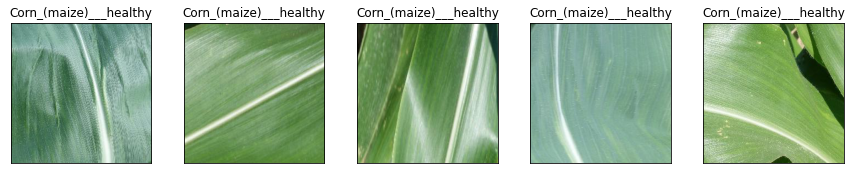

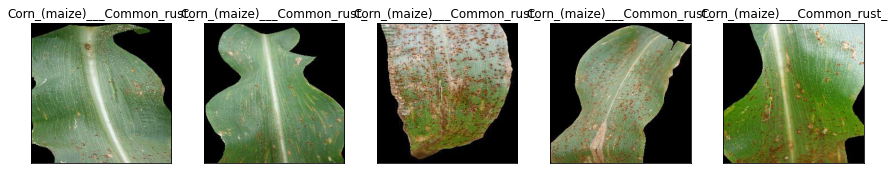

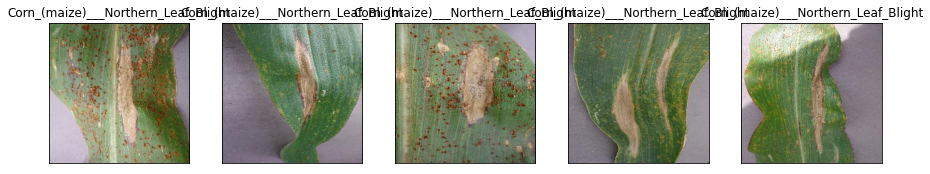

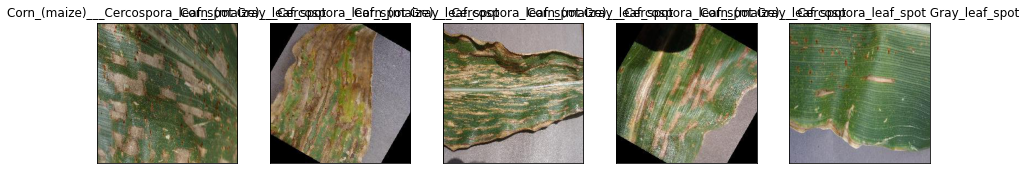

In [14]:
import matplotlib.image as mpimg
import random

numb_of_pic = 5
random.seed()

for fn in corn:
  rand_F = []
  for i in range(numb_of_pic):
    rand_F.append(random.randint(0, len(os.listdir('{}/{}'.format(corn_train_dir, fn)))))

  F_listdir = [os.listdir('{}/{}'.format(corn_train_dir, fn))[i] for i in rand_F]
  F_listdir = [os.path.join('{}/{}'.format(corn_train_dir, fn), fname) for fname in F_listdir]

  plt.figure(figsize=(15, 15))
  for i, image in enumerate(F_listdir):
    img = mpimg.imread(image)
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(fn)

## **Augmentation**

In [15]:
train_datagen_3 = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    # zoom_range=0.2,
                    # width_shift_range=0.2,
                    # height_shift_range=0.2,
                    fill_mode='nearest'
                    )
 
test_datagen_3 = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator_3 = train_datagen_3.flow_from_directory(
        corn_train_dir,
        target_size=(224, 224),  
        batch_size=64,
        class_mode='categorical',
        shuffle=True) # label data berupa kategori
 
validation_generator_3 = test_datagen_3.flow_from_directory(
        corn_validation_dir,
        target_size=(224, 224), 
        batch_size=64, 
        class_mode='categorical') # label data berupa kategori

Found 7316 images belonging to 4 classes.
Found 1829 images belonging to 4 classes.


In [17]:
num_class = validation_generator_3.num_classes

## **Training**

### **No Augmentation**

In [27]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    corn_train_dir, 
    color_mode = 'rgb', 
    batch_size = 64, 
    image_size = (224, 224),
    seed = 42,
    shuffle=True
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    corn_validation_dir, 
    color_mode = 'rgb', 
    batch_size = 64, 
    image_size = (224, 224),
    seed = 42,
    shuffle=True
)

Found 7316 files belonging to 4 classes.
Found 1829 files belonging to 4 classes.


In [28]:
class_names = validation_ds.class_names

In [29]:
class_names

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy']

In [30]:
# defining cnn
model_corn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(216, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation= 'softmax')
])

In [31]:
model_corn.compile(
    optimizer=tf.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_1 = model_corn.fit(training_ds, validation_data = validation_ds, epochs = 10)

Epoch 1/10
115/115 [==============================] - 22s 180ms/step - loss: 5.9485 - accuracy: 0.7734 - val_loss: 0.2242 - val_accuracy: 0.9196
Epoch 2/10
115/115 [==============================] - 21s 181ms/step - loss: 0.2146 - accuracy: 0.9217 - val_loss: 0.1847 - val_accuracy: 0.9448
Epoch 3/10
115/115 [==============================] - 21s 181ms/step - loss: 0.1590 - accuracy: 0.9415 - val_loss: 0.1526 - val_accuracy: 0.9535
Epoch 4/10
115/115 [==============================] - 21s 181ms/step - loss: 0.1015 - accuracy: 0.9617 - val_loss: 0.1621 - val_accuracy: 0.9595
Epoch 5/10
115/115 [==============================] - 21s 181ms/step - loss: 0.1131 - accuracy: 0.9597 - val_loss: 0.2649 - val_accuracy: 0.9256
Epoch 6/10
115/115 [==============================] - 21s 181ms/step - loss: 0.0824 - accuracy: 0.9712 - val_loss: 0.1722 - val_accuracy: 0.9535
Epoch 7/10
115/115 [==============================] - 21s 181ms/step - loss: 0.0827 - accuracy: 0.9698 - val_loss: 0.1072 - val_ac

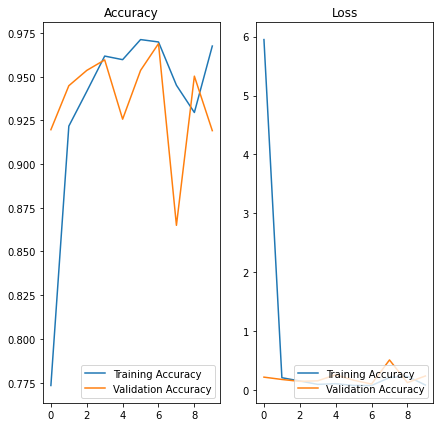

In [32]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Accuracy')
plt.plot(epochs_range, val_loss, label='Validation Accuracy')
plt.title('Loss')
plt.legend(loc='lower right')
plt.show()

**Model Evaluation**

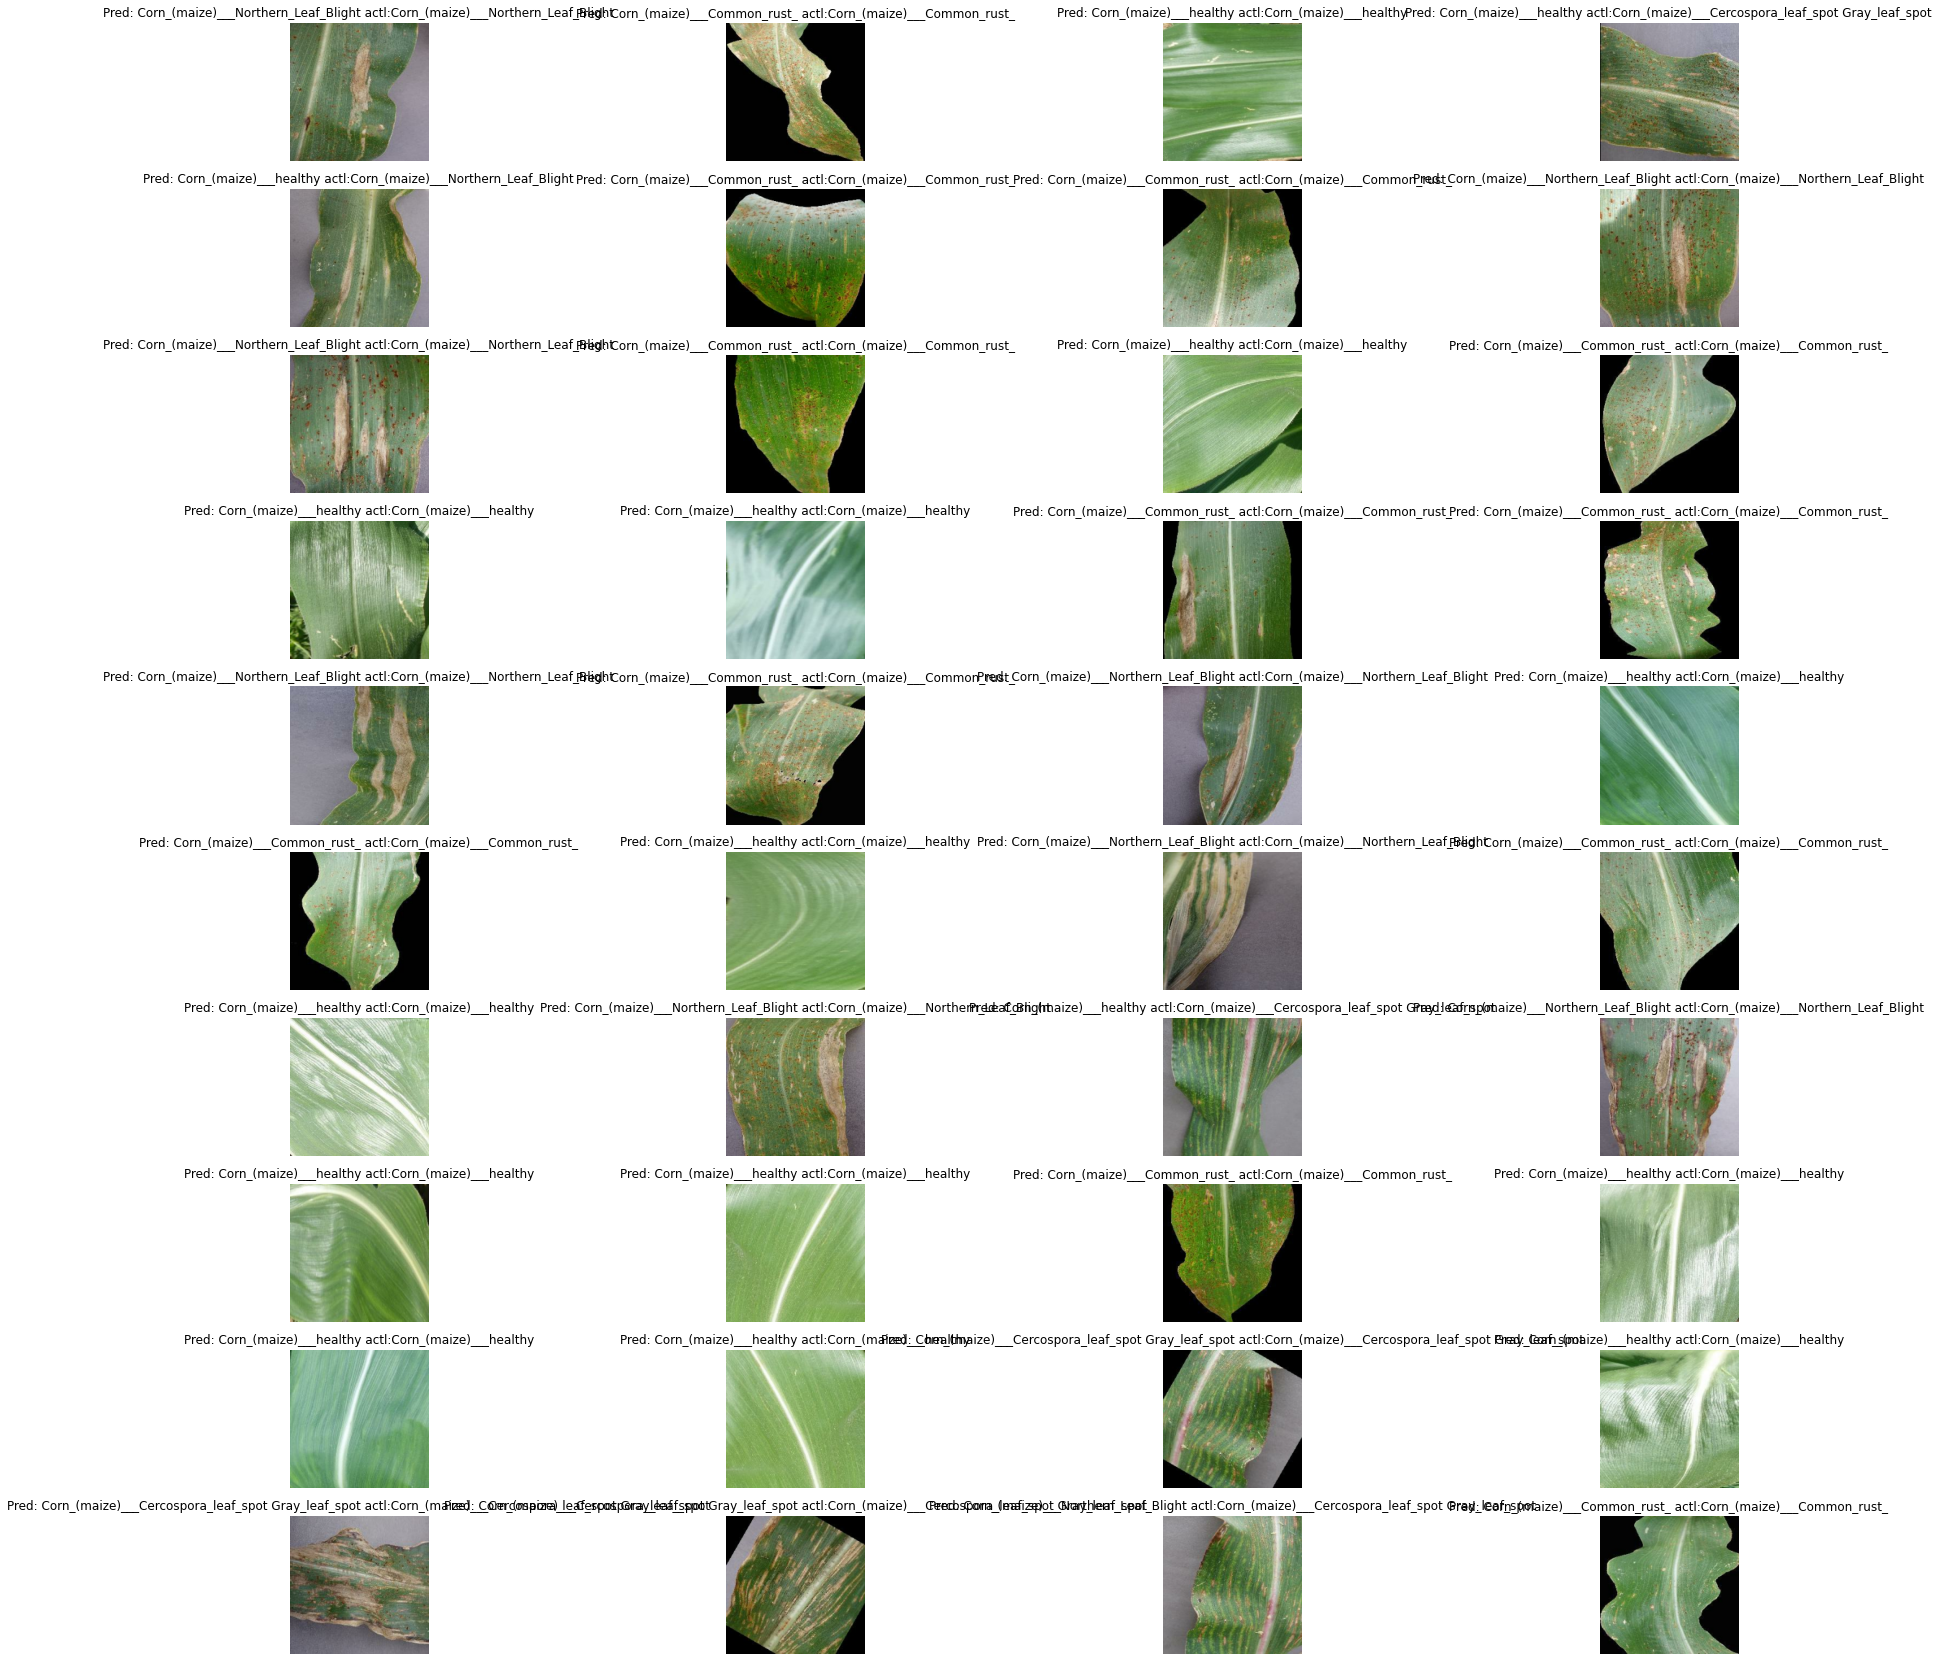

In [33]:
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in validation_ds.take(1):
    predictions = model_corn.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')

Saving common-rust-corn.jpg to common-rust-corn.jpg
Saving common-rust-corn-2.jpg to common-rust-corn-2.jpg
Saving common-rust-corn-3.jpg to common-rust-corn-3.jpg
Saving gray-leaf-spot-3.jpg to gray-leaf-spot-3.jpg
Saving grey-leaf-spot-corn.jpg to grey-leaf-spot-corn.jpg
Saving grey-leaf-spot-corn-2.jpg to grey-leaf-spot-corn-2.jpg
Saving healthy-corn.jpg to healthy-corn.jpg
Saving healthy-corn-2.jpg to healthy-corn-2.jpg
Saving healthy-corn-3.jpg to healthy-corn-3.jpg
Saving leaf-blight-corn.jpg to leaf-blight-corn.jpg
Saving leaf-blight-corn-2.jpg to leaf-blight-corn-2.jpg
Saving leaf-blight-corn-3.jpg to leaf-blight-corn-3.jpg


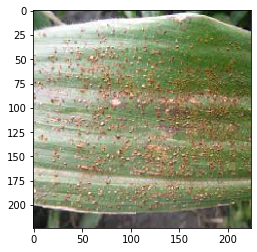


Pic name: common-rust-corn.jpg
Prediction: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


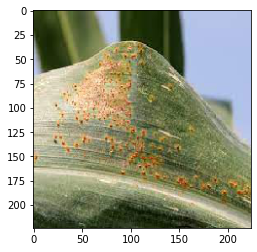


Pic name: common-rust-corn-2.jpg
Prediction: Corn_(maize)___Northern_Leaf_Blight


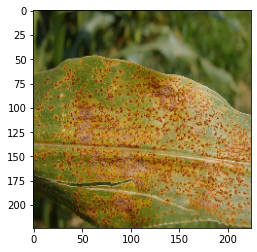


Pic name: common-rust-corn-3.jpg
Prediction: Corn_(maize)___Northern_Leaf_Blight


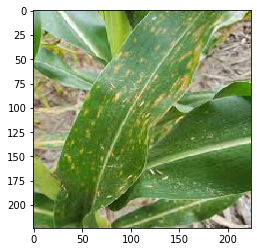


Pic name: gray-leaf-spot-3.jpg
Prediction: Corn_(maize)___healthy


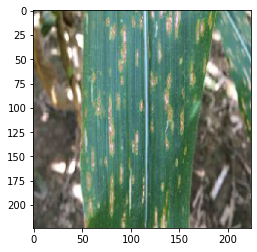


Pic name: grey-leaf-spot-corn.jpg
Prediction: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


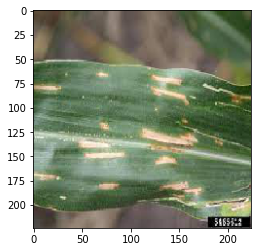


Pic name: grey-leaf-spot-corn-2.jpg
Prediction: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


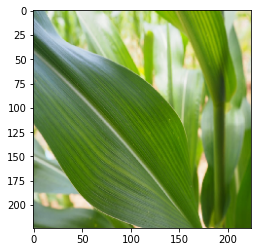


Pic name: healthy-corn.jpg
Prediction: Corn_(maize)___healthy


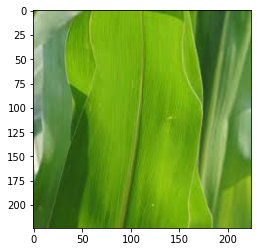


Pic name: healthy-corn-2.jpg
Prediction: Corn_(maize)___healthy


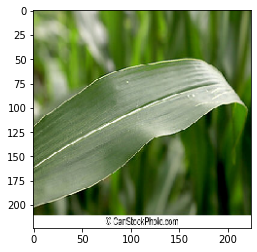


Pic name: healthy-corn-3.jpg
Prediction: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


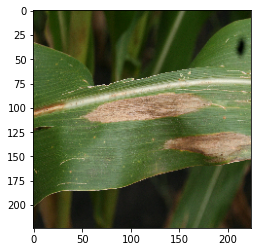


Pic name: leaf-blight-corn.jpg
Prediction: Corn_(maize)___Northern_Leaf_Blight


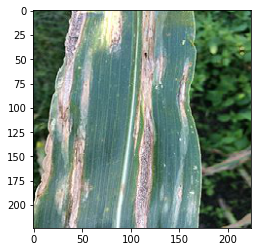


Pic name: leaf-blight-corn-2.jpg
Prediction: Corn_(maize)___Northern_Leaf_Blight


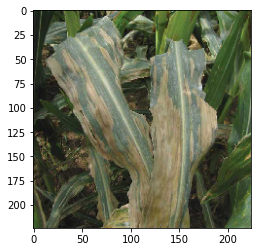


Pic name: leaf-blight-corn-3.jpg
Prediction: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


In [34]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  pred = model_corn.predict(images, batch_size=10)
  classes = np.argmax(pred)

  plt.imshow(img)
  plt.show()
  
  print('\nPic name: {}'.format(fn))
  print('Prediction: {}'.format(class_names[classes]))

### **Simple CNN**

In [38]:
# defining cnn
model_corn_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation= 'softmax')
])

In [39]:
from keras import optimizers
model_corn_2.compile(loss = 'categorical_crossentropy',
              # optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.005),
              optimizer = tf.optimizers.Adam(),
              metrics=['accuracy'])

In [40]:
history_3 = model_corn_2.fit(
    train_generator_3,
    steps_per_epoch = len(train_generator_3),
    epochs = 15,
    validation_data = validation_generator_3,
    validation_steps = len(validation_generator_3),
    verbose = 2
)

Epoch 1/15
115/115 - 73s - loss: 0.5540 - accuracy: 0.7749 - val_loss: 0.3341 - val_accuracy: 0.8524
Epoch 2/15
115/115 - 72s - loss: 0.2033 - accuracy: 0.9292 - val_loss: 0.2092 - val_accuracy: 0.9202
Epoch 3/15
115/115 - 71s - loss: 0.1492 - accuracy: 0.9474 - val_loss: 0.2070 - val_accuracy: 0.9235
Epoch 4/15
115/115 - 71s - loss: 0.1503 - accuracy: 0.9416 - val_loss: 0.1816 - val_accuracy: 0.9377
Epoch 5/15
115/115 - 71s - loss: 0.1171 - accuracy: 0.9569 - val_loss: 0.1431 - val_accuracy: 0.9502
Epoch 6/15
115/115 - 71s - loss: 0.1125 - accuracy: 0.9569 - val_loss: 0.2143 - val_accuracy: 0.9256
Epoch 7/15
115/115 - 71s - loss: 0.1030 - accuracy: 0.9623 - val_loss: 0.4235 - val_accuracy: 0.8677
Epoch 8/15
115/115 - 72s - loss: 0.1018 - accuracy: 0.9602 - val_loss: 0.1406 - val_accuracy: 0.9519
Epoch 9/15
115/115 - 71s - loss: 0.0935 - accuracy: 0.9661 - val_loss: 0.1345 - val_accuracy: 0.9574
Epoch 10/15
115/115 - 71s - loss: 0.0849 - accuracy: 0.9682 - val_loss: 0.1438 - val_accura

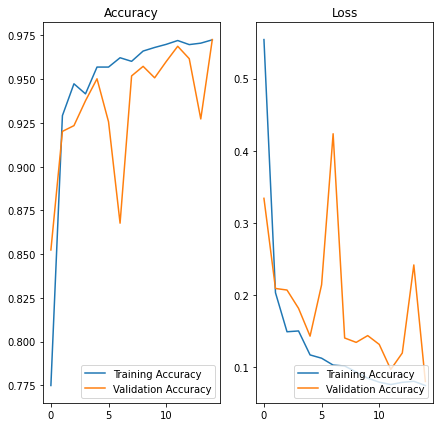

In [41]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Accuracy')
plt.plot(epochs_range, val_loss, label='Validation Accuracy')
plt.title('Loss')
plt.legend(loc='lower right')
plt.show()

**Evaluate Model**

In [ ]:
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in validation_ds.take(1):
    predictions = model_corn_2.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')

Saving common-rust-corn-2-salah.jpg to common-rust-corn-2-salah.jpg
Saving common-rust-corn-3-salah.jpg to common-rust-corn-3-salah.jpg
Saving common-rust-corn-salah.jpg to common-rust-corn-salah.jpg
Saving gray-leaf-spot-3-salah.jpg to gray-leaf-spot-3-salah.jpg
Saving grey-leaf-spot-corn-2-benar.jpg to grey-leaf-spot-corn-2-benar.jpg
Saving grey-leaf-spot-corn-benar.jpg to grey-leaf-spot-corn-benar.jpg
Saving healthy-corn-2-benar.jpg to healthy-corn-2-benar.jpg
Saving healthy-corn-3-salah.jpg to healthy-corn-3-salah.jpg
Saving healthy-corn-benar.jpg to healthy-corn-benar.jpg
Saving leaf-blight-corn-2-benar.jpg to leaf-blight-corn-2-benar.jpg
Saving leaf-blight-corn-3.jpg to leaf-blight-corn-3.jpg
Saving leaf-blight-corn-benar.jpg to leaf-blight-corn-benar.jpg


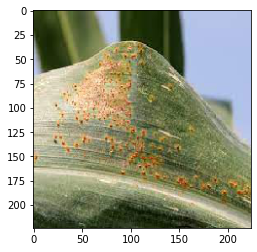


Pic name: common-rust-corn-2-salah.jpg
Prediction: Corn_(maize)___Northern_Leaf_Blight


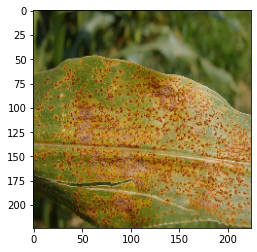


Pic name: common-rust-corn-3-salah.jpg
Prediction: Corn_(maize)___Northern_Leaf_Blight


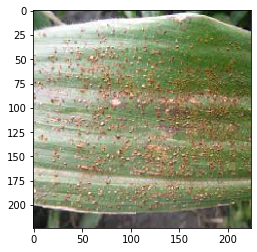


Pic name: common-rust-corn-salah.jpg
Prediction: Corn_(maize)___Northern_Leaf_Blight


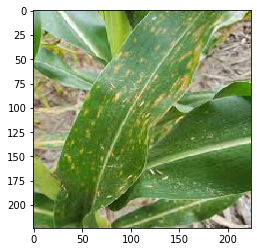


Pic name: gray-leaf-spot-3-salah.jpg
Prediction: Corn_(maize)___healthy


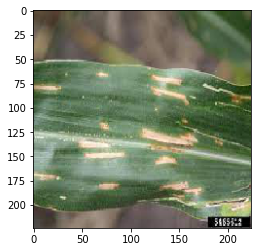


Pic name: grey-leaf-spot-corn-2-benar.jpg
Prediction: Corn_(maize)___healthy


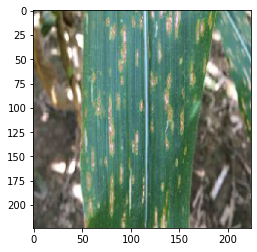


Pic name: grey-leaf-spot-corn-benar.jpg
Prediction: Corn_(maize)___Northern_Leaf_Blight


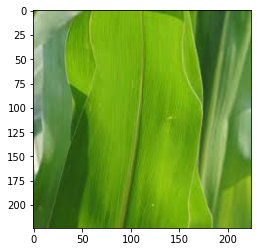


Pic name: healthy-corn-2-benar.jpg
Prediction: Corn_(maize)___healthy


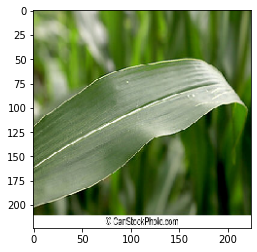


Pic name: healthy-corn-3-salah.jpg
Prediction: Corn_(maize)___healthy


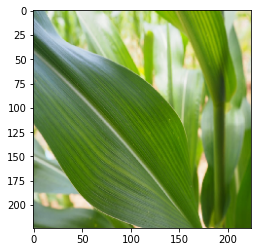


Pic name: healthy-corn-benar.jpg
Prediction: Corn_(maize)___healthy


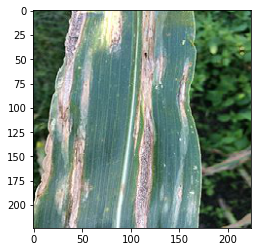


Pic name: leaf-blight-corn-2-benar.jpg
Prediction: Corn_(maize)___Northern_Leaf_Blight


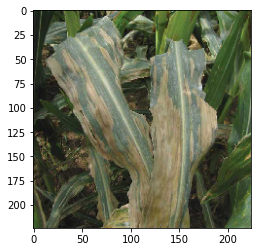


Pic name: leaf-blight-corn-3.jpg
Prediction: Corn_(maize)___Northern_Leaf_Blight


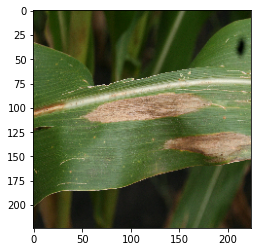


Pic name: leaf-blight-corn-benar.jpg
Prediction: Corn_(maize)___Northern_Leaf_Blight


In [45]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  pred = model_corn_2.predict(images, batch_size=10)
  classes = np.argmax(pred)

  plt.imshow(img)
  plt.show()
  
  print('\nPic name: {}'.format(fn))
  print('Prediction: {}'.format(class_names[classes]))

## **Save model**

In [35]:
model_corn.save('model_corn_1.h5')

In [46]:
model_corn_2.save('model_corn_2.h5')

In [36]:
!pip install tensorflowjs
!tensorflowjs_converter \
    --input_format=keras \
    model_corn_1.h5 \
    /tmp/my_tfjs_model_corn_1

     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 112kB 12.5MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0
2021-06-02 12:06:06.910085: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [37]:
!zip -r /tmp/corn_1.zip /tmp/my_tfjs_model_corn_1
files.download("/tmp/corn_1.zip")

  adding: tmp/my_tfjs_model_corn_1/ (stored 0%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard11of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard14of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard16of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard19of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard18of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard10of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard15of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard4of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard2of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_corn_1/model.json (deflated 85%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard12of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard8of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_corn_1/group1-shard1of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_cor

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **JSON Response**

In [47]:
# corn_prediction = tf.keras.models.model_from_json(loaded_model_json)
corn_prediction = tf.keras.models.load_model('model_corn_2.h5')

In [51]:
from keras.preprocessing import image

img = image.load_img('healthy-corn-3-salah.jpg', target_size=(224, 224))
x = image.img_to_array(img)
# x = x / 255
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

images = np.vstack([x])

prediction = corn_prediction.predict(images.tolist())
# print(imag.tolist())
confidence = '%.3f'%(np.amax(prediction)*100)
disease = class_names[np.argmax(prediction)]

In [52]:
disease, confidence

('Corn_(maize)___healthy', '100.000')

In [53]:
import json
response_json = {
        "disease" : disease,
        "confidence" : str(confidence) + '%'
    }
aaa = json.dumps(response_json)

In [54]:
aaa

'{"disease": "Corn_(maize)___healthy", "confidence": "100.000%"}'